In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.1 MB/s eta 0:00:00


In [2]:
import numpy as np

In [12]:
from ultralytics import YOLO

model = YOLO('/content/sample_data/models/yolo11m-obb_d.pt')
coord = model.predict("/content/sample_data/pics/img1.jpg", save=True, conf=0.15)


image 1/1 /content/sample_data/pics/img1.jpg: 352x640 15 frets, 1 neck, 1 nut, 643.2ms
Speed: 2.2ms preprocess, 643.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/obb/predict3


In [13]:
res = coord[0]

print("Атрибуты:", [attr for attr in dir(res) if not attr.startswith('_')][:15])
print("Есть ли .obb?", hasattr(res, 'obb') and res.obb is not None)
print("Есть ли .boxes?", hasattr(res, 'boxes') and res.boxes is not None)
print("Классы:", res.names)
if hasattr(res, 'obb') and res.obb is not None:
    print("Количество OBB:", len(res.obb))
if hasattr(res, 'boxes') and res.boxes is not None:
    print("Количество обычных боксов:", len(res.boxes))

Атрибуты: ['boxes', 'cpu', 'cuda', 'keypoints', 'masks', 'names', 'new', 'numpy', 'obb', 'orig_img', 'orig_shape', 'path', 'plot', 'probs', 'save']
Есть ли .obb? True
Есть ли .boxes? False
Классы: {0: 'capo', 1: 'fret', 2: 'neck', 3: 'nut'}
Количество OBB: 17


In [14]:
detections = []
if res.obb is not None and len(res.obb) > 0:
    xywhr = res.obb.xywhr.cpu().numpy()
    cls_ids = res.obb.cls.cpu().numpy().astype(int)
    confs = res.obb.conf.cpu().numpy()

    for i in range(len(xywhr)):
        x, y, w, h, angle_deg = xywhr[i]
        angle_deg = angle_deg % 360
        angle_rad = np.radians(angle_deg)  # в радианы для расчётов

        detections.append({
            'class': res.names[cls_ids[i]],
            'xc': float(x),
            'yc': float(y),
            'w': float(w),
            'h': float(h),
            'angle': float(angle_rad),
            'angle_deg': float(angle_deg),
            'conf': float(confs[i])
        })

print(f"\n Всего объектов: {len(detections)}")
print("№  Класс    Центр(x,y)     W×H     Угол°   Conf")
print("-" * 50)
for i, d in enumerate(detections):
    print(f"{i+1:2d}. {d['class']:<8} "
          f"({d['xc']:5.1f},{d['yc']:5.1f}) "
          f"{d['w']:4.1f}×{d['h']:4.1f} "
          f"{d['angle_deg']:5.1f}° "
          f"{d['conf']:5.2f}")


 Всего объектов: 17
№  Класс    Центр(x,y)     W×H     Угол°   Conf
--------------------------------------------------
 1. nut      (2065.9,492.7) 190.5×17.3   1.4°  0.90
 2. neck     (1238.7,656.5) 244.4×1457.0   1.3°  0.77
 3. fret     (1609.8,602.0) 192.9× 9.2   1.4°  0.36
 4. fret     (1819.6,540.5) 199.2×10.1   1.4°  0.35
 5. fret     (1513.2,623.7) 206.2× 9.5   1.4°  0.34
 6. fret     (1937.1,521.0) 190.5× 9.6   1.4°  0.33
 7. fret     (1712.5,574.3) 188.7× 9.0   1.4°  0.33
 8. fret     (1252.7,674.8) 229.9× 9.4   1.4°  0.30
 9. fret     (1420.5,638.2) 194.9× 9.6   1.4°  0.27
10. fret     (1332.4,646.1) 208.9× 9.3   1.4°  0.22
11. fret     (905.4,733.9) 230.0× 9.2   1.4°  0.22
12. fret     (1101.4,697.8) 206.4× 9.4   1.4°  0.22
13. fret     (1033.4,713.3) 224.2× 9.5   1.4°  0.21
14. fret     (967.5,726.0) 222.9× 8.6   1.4°  0.21
15. fret     (1172.7,675.6) 210.5× 9.4   1.4°  0.20
16. fret     (687.9,772.7) 229.9× 8.5   1.4°  0.17
17. fret     (740.9,778.1) 239.7× 9.7   1.4°  0.1

In [15]:
neck_boxes = [d for d in detections if d['class'] == 'neck']
nut_boxes  = [d for d in detections if d['class'] == 'nut']
fret_boxes = [d for d in detections if d['class'] == 'fret']

nut = nut_boxes[0]

print(f"neck: {len(neck_boxes)}, nut: {len(nut_boxes)}, fret: {len(fret_boxes)}")

neck: 1, nut: 1, fret: 15


In [16]:
nut_center = np.array([nut['xc'], nut['yc']])

# самый дальний лад от порожка
last_fret = max(
    fret_boxes,
    key=lambda d: np.linalg.norm(
        np.array([d['xc'], d['yc']]) - nut_center
    )
)

fret_center = np.array([last_fret['xc'], last_fret['yc']])

axis_vec = fret_center - nut_center
axis_vec = axis_vec / np.linalg.norm(axis_vec)   # единичный вектор

axis_angle = np.arctan2(axis_vec[1], axis_vec[0])


In [17]:
def proj_on_axis(d):
    pt = np.array([d['xc'], d['yc']])
    return np.dot(pt - nut_center, axis_vec)

fret_boxes_sorted = sorted(fret_boxes, key=proj_on_axis)

start_saddle = nut
end_saddle   = fret_boxes_sorted[-1]


In [18]:
def get_string_positions(box, outer_gap_ratio=0.086):
    """
    6 точек крепления струн на объекте (порожек).
    """
    xc, yc = box['xc'], box['yc']
    angle = box['angle']  # радианы, как пришло из YOLO

    # ширина поперёк струн — длинная сторона OBB
    W = max(box['w'], box['h'])

    outer_gap = outer_gap_ratio * W
    string_span = W - 2 * outer_gap
    step = string_span / 5.0

    # направление поперёк струн (вдоль порожка)
    perp_vec = np.array([
        np.cos(angle + np.pi / 2),
        np.sin(angle + np.pi / 2)
    ])

    offsets = np.linspace(-string_span / 2, string_span / 2, 6)

    points = np.array([
        [xc, yc] + off * perp_vec for off in offsets
    ])

    return points


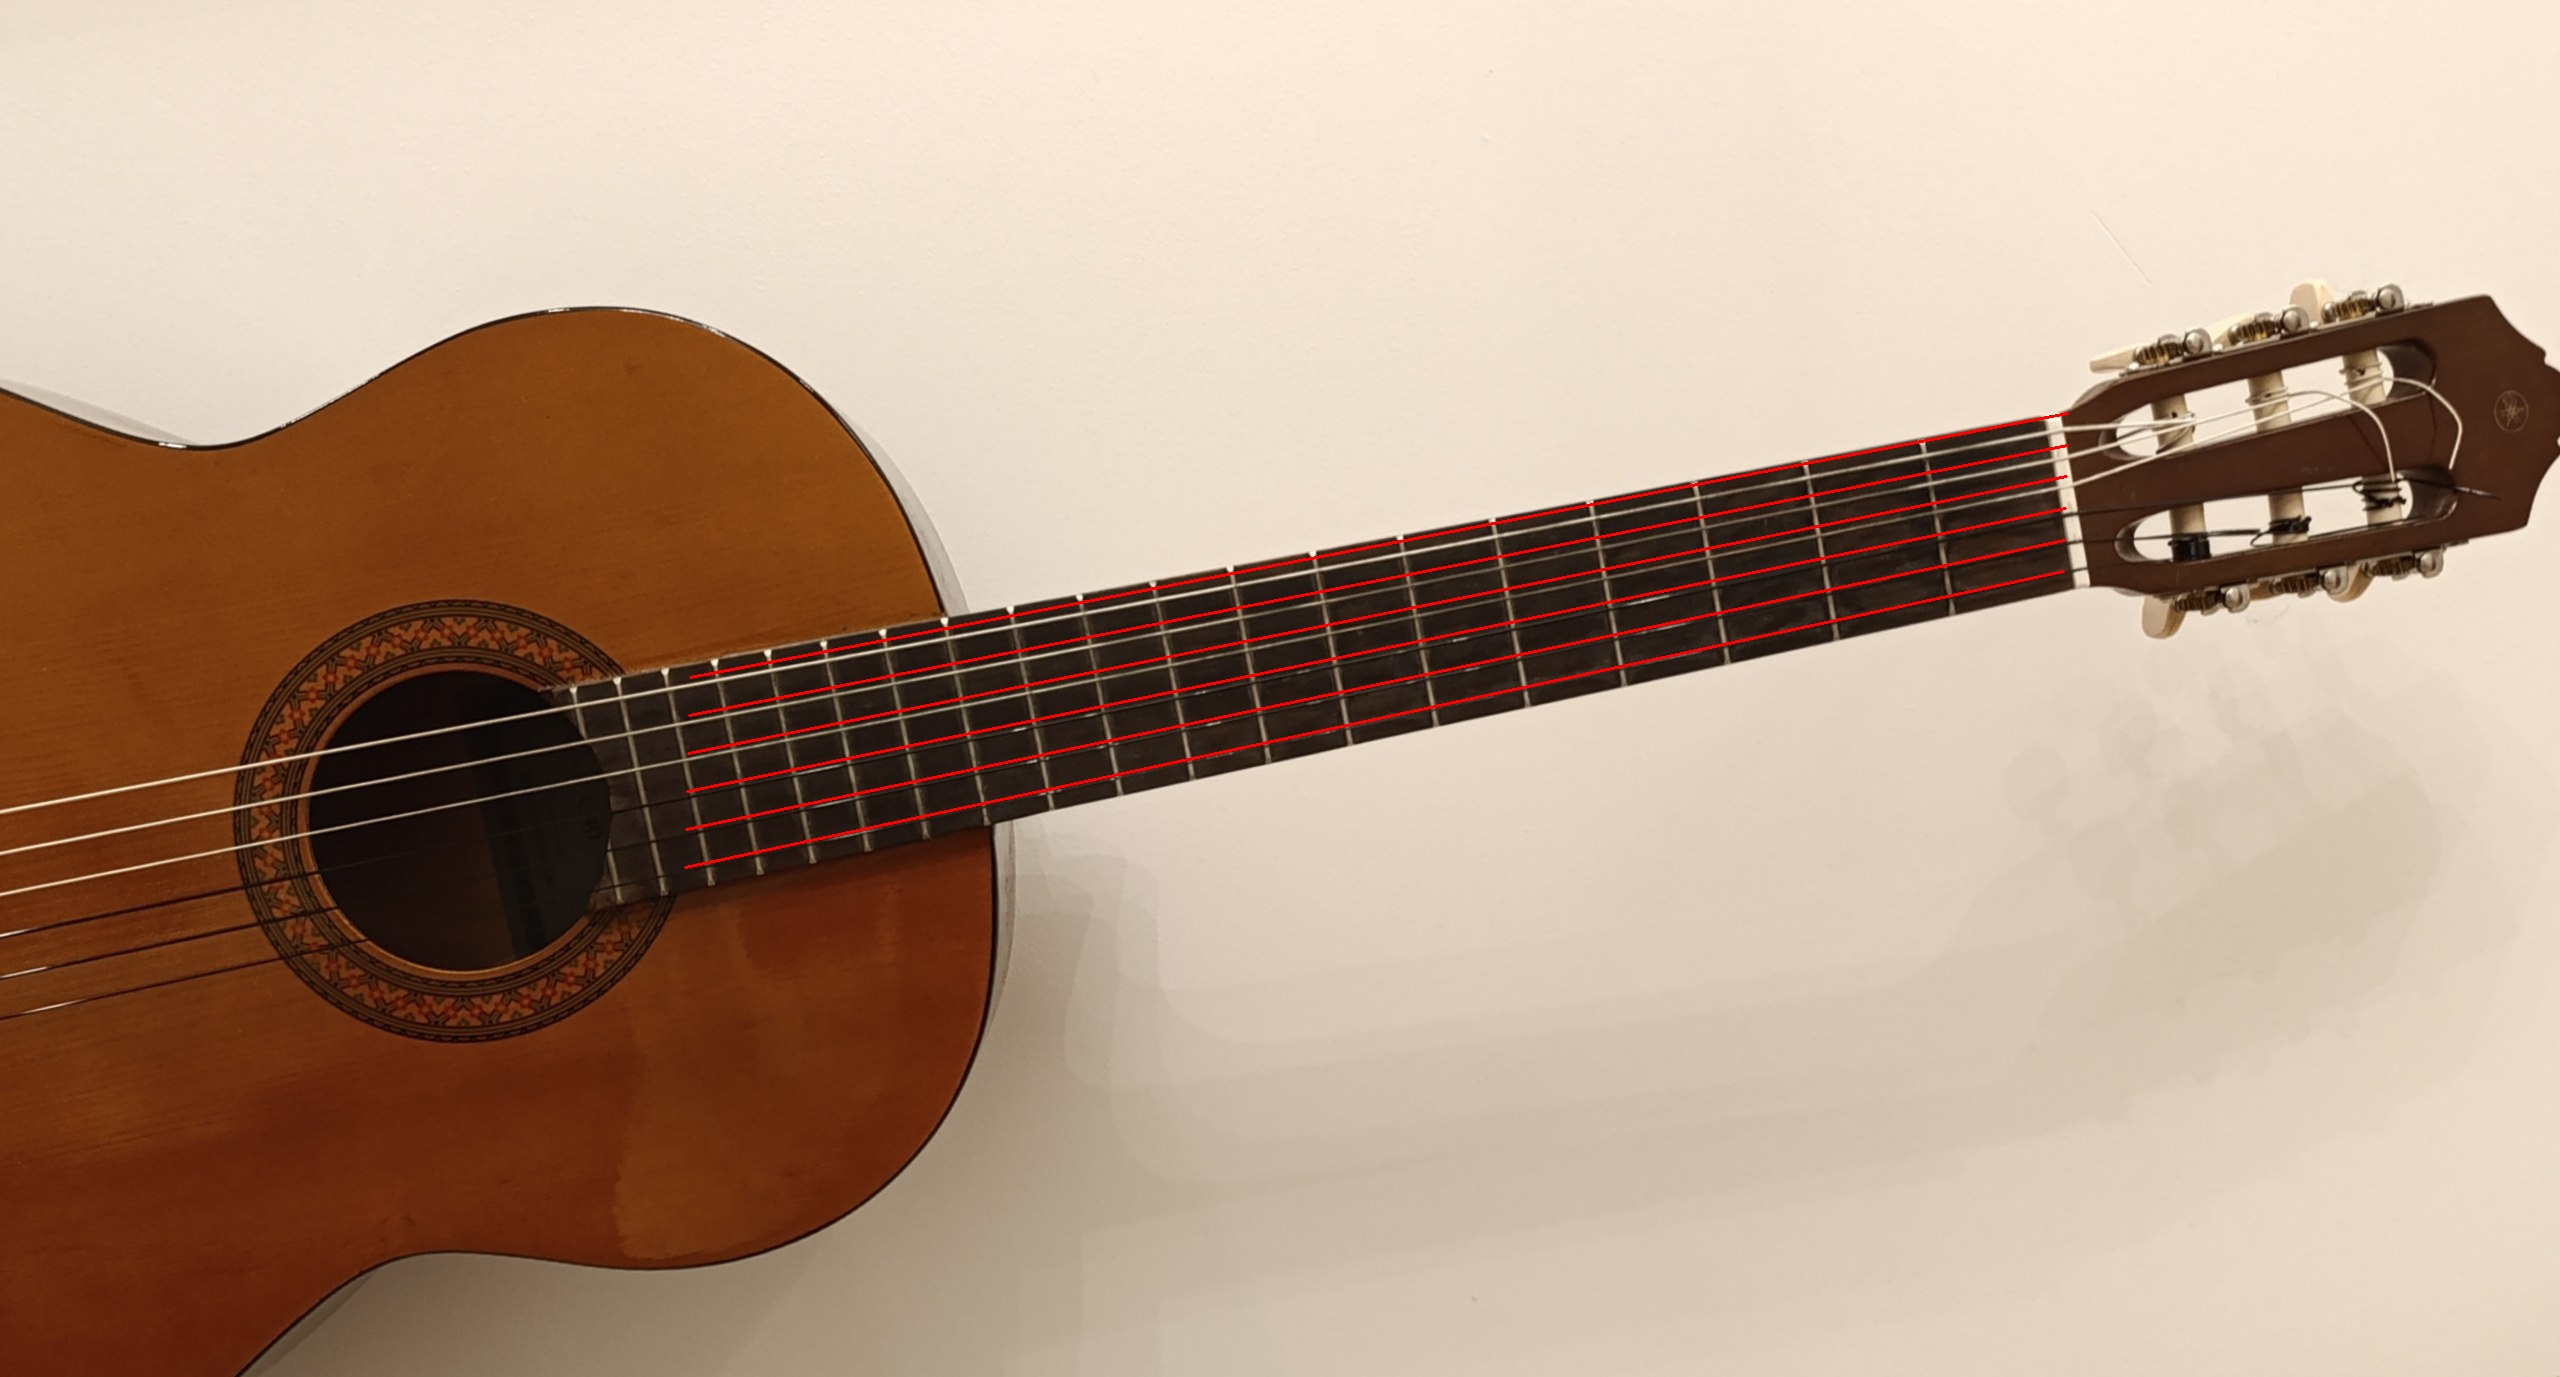

In [19]:
import cv2
from IPython.display import display, Image

start_pts = get_string_positions(start_saddle)
end_pts   = get_string_positions(end_saddle)

strings = []
for i in range(6):
    strings.append({
        'start': start_pts[i],
        'end':   end_pts[i],
        'length': np.linalg.norm(end_pts[i] - start_pts[i])
    })


img = res.orig_img.copy()

for s in strings:
    pt1 = tuple(s['start'].astype(int))
    pt2 = tuple(s['end'].astype(int))
    cv2.line(img, pt1, pt2, (0, 0, 255), 2)

out_path = "/content/strings_result.jpg"
cv2.imwrite(out_path, img)
display(Image(filename=out_path))